# Verify Mean Reversion Signals using PNL

Signals are identifed by the hmm model and imported into the system. 

    When signal = 1, we enter the mean reversion position.
    When signal = 0, we do not trade. 


Mean Reversion Strategy:

    a.If return in the past 21 days > 0.02, we sell
    b.If return in the past 21 days < -0.02, we buy
    c.We close the position every 10 days 

 

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

import pandas as pd
from datetime import datetime

In [2]:

class RSI_Oversold(bt.Indicator):
    lines = ('oversold',)
    
    params = (
        ('level', 30),    
    )

    def __init__(self):
        self.lines.oversold = bt.indicators.RSI(self.data) < self.p.level

        
class DummyInd(bt.Indicator):
    lines = ('dummyline',)

    params = (('value', 5),)

    def __init__(self):
        self.lines.dummyline = bt.Max(0.0, self.params.value)

        
# Create a Stratey
class BackTradingStrategy(bt.Strategy):
    params = (
        ('period', 128),
        ("max_days_in_trade", 10)
    )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
        
    def read_signals(self):
        signal_data = pd.read_csv("hmm_regime_signals.csv")
        signal_data["datetime"] = signal_data["datetime"].apply(lambda x: datetime.strptime(x,"%m/%d/%Y"))

        signal_data = signal_data.set_index('datetime')
        
        """
        start_date = '2013-02-11'
        end_date = '2018-02-09'
        signals = signal_data['state'].loc[start_date:end_date]               
        dt = self.datadate(0).strftime('%Y-%m-%d')
        #print(signal_data.iloc[0])
        print(signal_data['state'].loc[dt])
        """
        
        return signal_data
        

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.dataopen = self.datas[0].open
        self.datadate = self.datas[0].datetime.date
        self.days_in_trade = 0
        self.max_days_in_trade_mr = 10
        self.max_days_in_trade_mo = 21
        self.num_mr = 21
        self.num_mo = 21*6
        self.regime_state = 0
        self.mrr = 0.02
        self.mor = 0.05
        self.signal_data = self.read_signals()
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period) 
        
        

        
    def stock_return(self, n):
        """calculate return in the past n days """        
        r = (self.dataclose[0] - self.dataclose[-n+1])/self.dataclose[-n+1]
        return r   
    

    def next(self):
        # Simply log the closing price of the series from the reference
        
        self.log('Close, %.2f' % self.dataclose[0])        
                 
        dt = self.datadate(0).strftime('%Y-%m-%d')
        
        signal = self.signal_data['state'].loc[dt]
        
        # Check if we are in the market
        if not self.position:
            # if we do not have a position
            
            if signal == 1:
                # mean reversion
                # we BUY if return in the past num_mr days is less than -mrr
                
                r = self.stock_return(self.num_mr)
                
                if (r < - self.mrr):
                    # BUY, BUY, BUY!!! (with all possible default parameters)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()
                    
                    self.days_in_trade = 1
                    
                    self.regime_state = 1
                    
                    
                # we SELL if return in the past num_mr days is more than mrr    
                elif (r > self.mrr):                

                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.sell()
                    
                    self.days_in_trade = 1
                    
                    self.regime_state = 1
            
            else:
                
                    self.regime_state = 0
                    
                    self.days_in_trade = 0
                
            

        else:
            # if we have a position
            
            self.days_in_trade += 1
            
            # mean reversion
            if (self.regime_state == 1):
            
                # close the position if regime shift or after holding it for max_mr days.
                if signal == 0 or self.days_in_trade == self.max_days_in_trade_mr:
                    
                    if self.position.size > 0:
                        # SELL to close position
                        self.log('Close poition---SELL EMPTY, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.sell()
                        
                        self.days_in_trade = 0
                        self.regime_state = 0
                
                    else:
                        # BUY to close position 
                        self.log('Close poition---BUY EMPTY, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()
                        
                        self.days_in_trade = 0                        
                        self.regime_state = 0
                        
            
            
            
                 
       


In [3]:


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(BackTradingStrategy)

    datapath = os.path.join('../../../datas/spx-2013-2018.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        #fromdate=datetime.datetime(2018, 1, 1),
        # Do not pass values before this date
        #todate=datetime.datetime(2018, 2, 9),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)
    
    

    # Write output
    cerebro.addwriter(bt.WriterFile, out='verify_mean_reversion.csv',csv=True)
    
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2013-08-13, Close, 1694.16
2013-08-14, Close, 1685.39
2013-08-15, Close, 1661.32
2013-08-16, Close, 1655.83
2013-08-19, Close, 1646.06
2013-08-20, Close, 1652.35
2013-08-21, Close, 1642.80
2013-08-22, Close, 1656.96
2013-08-23, Close, 1663.50
2013-08-26, Close, 1656.78
2013-08-27, Close, 1630.48
2013-08-28, Close, 1634.96
2013-08-29, Close, 1638.17
2013-08-30, Close, 1632.97
2013-09-03, Close, 1639.77
2013-09-04, Close, 1653.08
2013-09-05, Close, 1655.08
2013-09-06, Close, 1655.17
2013-09-09, Close, 1671.71
2013-09-10, Close, 1683.99
2013-09-11, Close, 1689.13
2013-09-12, Close, 1683.42
2013-09-13, Close, 1687.99
2013-09-16, Close, 1697.60
2013-09-17, Close, 1704.76
2013-09-18, Close, 1725.52
2013-09-19, Close, 1722.34
2013-09-20, Close, 1709.91
2013-09-23, Close, 1701.84
2013-09-24, Close, 1697.42
2013-09-25, Close, 1692.77
2013-09-26, Close, 1698.67
2013-09-27, Close, 1691.75
2013-09-30, Close, 1681.55
2013-10-01, Close, 1695.00
2013-10-02, Close, 

2014-12-29, Close, 2090.57
2014-12-30, Close, 2080.35
2014-12-31, Close, 2058.90
2015-01-02, Close, 2058.20
2015-01-05, Close, 2020.58
2015-01-06, Close, 2002.61
2015-01-07, Close, 2025.90
2015-01-08, Close, 2062.14
2015-01-09, Close, 2044.81
2015-01-12, Close, 2028.26
2015-01-13, Close, 2023.03
2015-01-14, Close, 2011.27
2015-01-15, Close, 1992.67
2015-01-16, Close, 2019.42
2015-01-20, Close, 2022.55
2015-01-21, Close, 2032.12
2015-01-22, Close, 2063.15
2015-01-23, Close, 2051.82
2015-01-26, Close, 2057.09
2015-01-27, Close, 2029.55
2015-01-28, Close, 2002.16
2015-01-29, Close, 2021.25
2015-01-30, Close, 1994.99
2015-02-02, Close, 2020.85
2015-02-03, Close, 2050.03
2015-02-04, Close, 2041.51
2015-02-05, Close, 2062.52
2015-02-06, Close, 2055.47
2015-02-09, Close, 2046.74
2015-02-10, Close, 2068.59
2015-02-11, Close, 2068.53
2015-02-12, Close, 2088.48
2015-02-13, Close, 2096.99
2015-02-17, Close, 2100.34
2015-02-18, Close, 2099.68
2015-02-19, Close, 2097.45
2015-02-20, Close, 2110.30
2

2016-03-07, Close, 2001.76
2016-03-08, Close, 1979.26
2016-03-09, Close, 1989.26
2016-03-10, Close, 1989.57
2016-03-11, Close, 2022.19
2016-03-14, Close, 2019.64
2016-03-15, Close, 2015.93
2016-03-16, Close, 2027.22
2016-03-17, Close, 2040.59
2016-03-17, SELL CREATE, 2040.59
2016-03-18, Close, 2049.58
2016-03-18, Close poition---BUY EMPTY, 2049.58
2016-03-21, Close, 2051.60
2016-03-22, Close, 2049.80
2016-03-23, Close, 2036.71
2016-03-24, Close, 2035.94
2016-03-28, Close, 2037.05
2016-03-29, Close, 2055.01
2016-03-30, Close, 2063.95
2016-03-31, Close, 2059.74
2016-04-01, Close, 2072.78
2016-04-04, Close, 2066.13
2016-04-05, Close, 2045.17
2016-04-06, Close, 2066.66
2016-04-07, Close, 2041.91
2016-04-08, Close, 2047.60
2016-04-11, Close, 2041.99
2016-04-12, Close, 2061.72
2016-04-13, Close, 2082.42
2016-04-14, Close, 2082.78
2016-04-15, Close, 2080.73
2016-04-18, Close, 2094.34
2016-04-19, Close, 2100.80
2016-04-19, SELL CREATE, 2100.80
2016-04-20, Close, 2102.40
2016-04-21, Close, 2091

2017-11-21, Close, 2599.03
2017-11-22, Close, 2597.08
2017-11-24, Close, 2602.42
2017-11-27, Close, 2601.42
2017-11-28, Close, 2627.04
2017-11-29, Close, 2626.07
2017-11-30, Close, 2647.58
2017-12-01, Close, 2642.22
2017-12-04, Close, 2639.44
2017-12-05, Close, 2629.57
2017-12-06, Close, 2629.27
2017-12-07, Close, 2636.98
2017-12-08, Close, 2651.50
2017-12-11, Close, 2659.99
2017-12-12, Close, 2664.11
2017-12-13, Close, 2662.85
2017-12-14, Close, 2652.01
2017-12-15, Close, 2675.81
2017-12-18, Close, 2690.16
2017-12-19, Close, 2681.47
2017-12-20, Close, 2679.25
2017-12-21, Close, 2684.57
2017-12-22, Close, 2683.34
2017-12-26, Close, 2680.50
2017-12-27, Close, 2682.62
2017-12-28, Close, 2687.54
2017-12-29, Close, 2673.61
2018-01-02, Close, 2695.81
2018-01-03, Close, 2713.06
2018-01-04, Close, 2723.99
2018-01-05, Close, 2743.15
2018-01-08, Close, 2747.71
2018-01-09, Close, 2751.29
2018-01-10, Close, 2748.23
2018-01-11, Close, 2767.56
2018-01-12, Close, 2786.24
2018-01-16, Close, 2776.42
2

In [4]:
# calculate pnl using excel data
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('verify_mean_reversion.csv').fillna(value = 0)
data = data[:1260]

df = data[['datetime', 'pnlplus', 'pnlminus']].copy()
n = len(df)

df['cumulative_pnl'] = df['pnlplus']

cpnl = 0.
count_plus = 0
count_minus = 0

for i in range(n):
    plus = df['pnlplus'].iloc[i]
    minus = df['pnlminus'].iloc[i]
    cpnl = cpnl + plus + minus
    df['cumulative_pnl'].iloc[i] = cpnl
    
    if (plus > 0.):
        count_plus +=1
    if (minus < 0.):
        count_minus +=1

    

/home/project/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
plus_percent = 1.0*count_plus/(count_plus*1.0+count_minus*1.0) 
print('percentage of trading that make positive profits = ', plus_percent)

percentage of trading that make positive profits =  0.5625


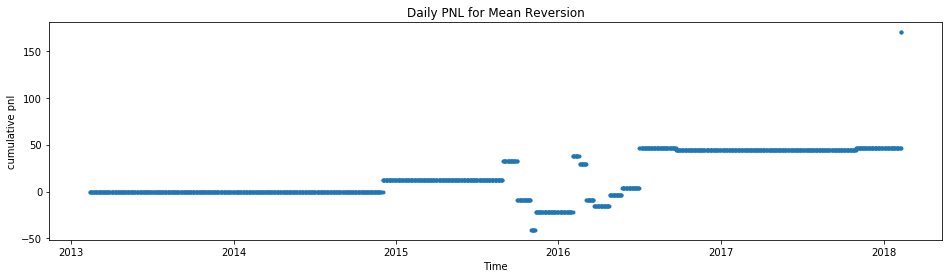

In [10]:
# convert string to datetime
df["datetime"] = df["datetime"].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S.%f"))

# plot PNL figures 
plt.figure(figsize=(16, 4))
plt.plot(df['datetime'], df['cumulative_pnl'] ,'.') 
plt.xlabel("Time")
plt.ylabel("cumulative pnl")
plt.title("Daily PNL for Mean Reversion")
plt.show()

In [11]:
print(df)

                       datetime  pnlplus  pnlminus  cumulative_pnl
0    2013-02-11 23:59:59.999989     0.00       0.0            0.00
1    2013-02-12 23:59:59.999989     0.00       0.0            0.00
2    2013-02-13 23:59:59.999989     0.00       0.0            0.00
3    2013-02-14 23:59:59.999989     0.00       0.0            0.00
4    2013-02-15 23:59:59.999989     0.00       0.0            0.00
5    2013-02-19 23:59:59.999989     0.00       0.0            0.00
6    2013-02-20 23:59:59.999989     0.00       0.0            0.00
7    2013-02-21 23:59:59.999989     0.00       0.0            0.00
8    2013-02-22 23:59:59.999989     0.00       0.0            0.00
9    2013-02-25 23:59:59.999989     0.00       0.0            0.00
10   2013-02-26 23:59:59.999989     0.00       0.0            0.00
11   2013-02-27 23:59:59.999989     0.00       0.0            0.00
12   2013-02-28 23:59:59.999989     0.00       0.0            0.00
13   2013-03-01 23:59:59.999989     0.00       0.0            